# MSD and diffusion coefficient

## Import packages

In [1]:
from fishmol import trj, msd
from cage_data import cage1_info
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fishmol import style

## Import information of the simulated system

In [2]:
from cage_data import cage1_info
# The simulation box
cell = cage1_info.cell
# Waters is a dict contains the indices of atoms of water molcules
waters = cage1_info.waters
water_indices = [[*water.values()] for water in waters]
print(water_indices)

[[14, 15, 16], [17, 18, 19], [143, 144, 145], [146, 147, 148], [272, 273, 274], [275, 276, 277], [401, 402, 403], [404, 405, 406]]


## Read trajectory data file

In [4]:
%%time
# The trajectory is a large file (517 MB)
traj = trj.Trajectory(timestep = 5, data = "/nobackup/rhtp48/data_ana/fishmol_examples/cage_data/cage1-500K.xyz", index = ":", cell = cell)

CPU times: user 45.4 s, sys: 1.47 s, total: 46.9 s
Wall time: 47.1 s


You can retrieve and confirm the simulation cell info

In [5]:
traj.cell

[[21.2944, 0.0, 0.0],
 [-4.6030371123, 20.7909480472, 0.0],
 [-0.9719093466, -1.2106211379, 15.1054299403]]

A test of `calc_com()` function is working

In [6]:
traj.frames[0][water_indices[0]].calc_com()

array([10.58631557, 19.90213351, 10.38000923])

## Calculate the centre of masses (CoMs) for water molecules

In [7]:
from fishmol.utils import update_progress # import the progress bar function

water_coms = np.zeros((traj.nframes, 3*len(water_indices)))

for i, frame in enumerate(traj.frames):
    # Calculate com
    coms = [frame[water_idx].calc_com() for water_idx in water_indices]
    water_coms[i] = np.asarray(coms).flatten()
    update_progress(i/traj.nframes)
    
# Add data to dateframe
columns=[]
for i in range(1, len(water_indices) + 1):
    columns += [f"water{i}_x", f"water{i}_y", f"water{i}_z"]

water_com_df = pd.DataFrame(columns=columns, data = water_coms)

# Write data to excel file
water_com_df.to_excel("test/cage1-500K-water-com.xlsx")
update_progress(1)

Progress: [■■■■■■■■■■■■■■■■■■■■] 100.0%


In [8]:
water_com_df.head()

,water1_x,water1_y,water1_z,water2_x,water2_y,water2_z,water3_x,water3_y,water3_z,water4_x,...,water5_z,water6_x,water6_y,water6_z,water7_x,water7_y,water7_z,water8_x,water8_y,water8_z
0,10.586316,19.902134,10.380009,0.624155,10.923925,8.298079,-1.967392,4.261146,12.241481,4.693672,...,4.725172,15.090375,8.649502,6.883228,17.759366,15.321196,2.865725,11.019290,3.578953,0.703805
1,10.597616,19.945151,10.393126,0.617881,10.942585,8.312331,-1.961926,4.253910,12.205821,4.689873,...,4.745156,15.076014,8.640429,6.849210,17.749958,15.278667,2.889409,11.049146,3.587807,0.663123
2,10.610208,20.003821,10.408405,0.610859,10.967922,8.330438,-1.953047,4.243309,12.156421,4.687198,...,4.767198,15.058083,8.628816,6.804086,17.738720,15.225162,2.920655,11.086905,3.600664,0.608757
3,10.622718,20.062112,10.416761,0.604688,10.993416,8.349495,-1.945208,4.229969,12.106099,4.687512,...,4.786539,15.040753,8.617851,6.760128,17.728982,15.181476,2.948253,11.122864,3.614650,0.558271
4,10.636664,20.122749,10.416813,0.597829,11.020753,8.373153,-1.941190,4.211549,12.054352,4.691621,...,4.808036,15.020218,8.605213,6.714651,17.717884,15.151479,2.970079,11.155729,3.629731,0.511643


In [9]:
del water_coms

### Calculate the mean squared displacement of water molecules

### Create the time data

In [11]:
start_idx = 0
t0 = start_idx * 5
t_end = t0 + 5*(len(water_com_df)-1) # 5 fs is the interval of traj
t = np.linspace(t0, t_end, num = len(water_com_df))

In [12]:
msd_d_df = pd.DataFrame()
msd_d_df["t"] = t[1:]

### Calculate the MSD and D

In [13]:
for i in range(len(water_indices)):
    temp = np.array(water_com_df.iloc[:, 3*i:3*i+3])
    msds = msd.msd_fft(temp)
    msd_d_df[f"water{i}_MSD"] = msds[1:]
    msd_d_df[f"water{i}_D"] = msds[1:] * 1E-16 / (6*t[1:]*1E-15)

In [14]:
msd_df = msd_d_df.iloc[:, 1:16:2]
d_df = msd_d_df.iloc[:, 2:17:2]

### Calculate average values of MSD and D

In [15]:
msd_d_df["Mean_MSD"] = msd_df.mean(axis=1)
msd_d_df["MSD_error"] = msd_df.std(axis=1) / 8**0.5
msd_d_df["Mean_D"] = d_df.mean(axis=1)
msd_d_df["D_error"] = d_df.std(axis=1) / 8**0.5

In [16]:
# Save the data
msd_d_df.to_excel("test/cage1-H2O-MSD-D-500K.xlsx")

## Plot the data

In [17]:
# skip the first 5 ps, that the system is still equilibrating
msd_d_df = msd_d_df.iloc[1000:,:]
msd_d_df["t"] = (msd_d_df["t"] -5000)
msd_d_df.head()

,t,water0_MSD,water0_D,water1_MSD,water1_D,water2_MSD,water2_D,water3_MSD,water3_D,water4_MSD,...,water5_MSD,water5_D,water6_MSD,water6_D,water7_MSD,water7_D,Mean_MSD,MSD_error,Mean_D,D_error
1000,5.0,4.093919,0.000014,19.722342,0.000066,2.003004,0.000007,33.566337,0.000112,1.458750,...,19.347635,0.000064,2.614106,0.000009,19.172680,0.000064,12.747347,4.198995,0.000042,0.000014
1001,10.0,4.095739,0.000014,19.746275,0.000066,2.003836,0.000007,33.597794,0.000112,1.458538,...,19.358398,0.000064,2.613060,0.000009,19.178147,0.000064,12.756473,4.202892,0.000042,0.000014
1002,15.0,4.097586,0.000014,19.770177,0.000066,2.004774,0.000007,33.629258,0.000112,1.458261,...,19.369117,0.000064,2.612067,0.000009,19.183779,0.000064,12.765627,4.206788,0.000042,0.000014
1003,20.0,4.099463,0.000014,19.794038,0.000066,2.005816,0.000007,33.660730,0.000112,1.457916,...,19.379795,0.000064,2.611117,0.000009,19.189575,0.000064,12.774806,4.210683,0.000042,0.000014
1004,25.0,4.101374,0.000014,19.817852,0.000066,2.006957,0.000007,33.692212,0.000112,1.457499,...,19.390432,0.000064,2.610204,0.000009,19.195537,0.000064,12.784008,4.214578,0.000042,0.000014


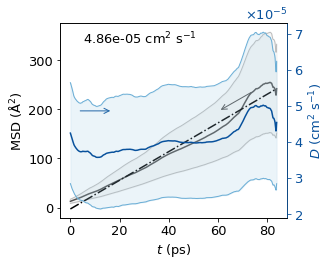

In [18]:
fig = plt.figure(figsize=(4.6,3.6))
ax  = fig.add_axes([0.16, 0.16, 0.685, 0.75])
color = "#08519c"
ax.plot(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"], color = "#525252")

ax.plot(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"] - msd_d_df["MSD_error"], linewidth = 1, color = "#bdbdbd")
ax.plot(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"] + msd_d_df["MSD_error"], linewidth = 1, color = "#bdbdbd")

ax.fill_between(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"] + msd_d_df["MSD_error"], msd_d_df["Mean_MSD"] - msd_d_df["MSD_error"], color= "#d9d9d9", alpha = 0.2)

linear_model = np.polyfit(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"],1)  
linear_model_fn = np.poly1d(linear_model) 

x_s = np.arange(msd_d_df["t"].min()/1000, msd_d_df["t"].max()/1000)  
ax.plot(x_s,linear_model_fn(x_s), color="k", ls ="-.")

ax1 = ax.twinx()
ax1.plot(msd_d_df["t"]/1000, msd_d_df["Mean_D"], color = color)
ax1.plot(msd_d_df["t"]/1000, msd_d_df["Mean_D"] - msd_d_df["D_error"], linewidth = 1, color = "#6baed6")
ax1.plot(msd_d_df["t"]/1000, msd_d_df["Mean_D"] + msd_d_df["D_error"], linewidth = 1, color = "#6baed6")

ax1.fill_between(msd_d_df["t"]/1000, msd_d_df["Mean_D"] + msd_d_df["D_error"], msd_d_df["Mean_D"] - msd_d_df["D_error"], color = "#9ecae1", alpha = 0.2)

ax.annotate("", xy=(0.7, 0.65), xycoords = "axes fraction",
            xytext=(0.85, 0.65), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", color = "#525252"))

ax.annotate("", xy=(0.23, 0.55), xycoords = "axes fraction",
            xytext=(0.08, 0.55), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", color = color))

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ax.text(xmin + 0.35*(xmax-xmin), ymin + 0.92*(ymax - ymin), "%.2e cm$^2$ s$^{-1}$"%(linear_model[0]/60000), ha = "center", va = "center")

ax.set_ylabel('MSD (Å$^2$)')
ax.set_xlabel('$t$ (ps)')

ax1.set_ylabel('$D$ (cm$^2$ s$^{-1}$)', color = color)
ax1.tick_params(axis='y', color = color, labelcolor = color)
ax1.spines['right'].set_color(color)
ax1.ticklabel_format(axis='y', style='sci', scilimits=[-4,4], useMathText=True)

# plt.savefig("cage1/average_msd_d_500K.jpg", dpi =600)

plt.show()